In [232]:
import lenstronomy
import pkg_resources as pr
pr.get_distribution("lenstronomy").version

'0.4.0'

In [233]:
import matplotlib.pyplot as plt
import pickle
from lenstronomy.Plots.output_plots import LensModelPlot
import numpy as np
import pandas as pd
import scipy.integrate as integrate
from lenstronomy.Sampling.parameters import Param
# from lenstronomy.Workflow.parameters import Param
import time as time
import corner
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math 

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Helvetica'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'custom'

sns.set(style='ticks', context='paper', font='Helvetica', font_scale=1.5)
sns.set_style({"xtick.direction": "in", "ytick.direction": "in", "axes.linewidth": .8, })

In [234]:
config_file = pd.read_excel("/Users/edenmolina/PycharmProjects/Quasar/Lenstronomy/LenstronomyConfig.xlsx", sheet_name="Master")
Names = config_file['Name']
Paths = config_file['Path']
RunBool = config_file['RunBool']
SourceVisibleBool = config_file['SourceVisble']

In [235]:
def getData(Path, LensName, sourcevisiblebool):
    """
    Path: path of the pickle file
    LensName: Name of the lenss to be worked with
    SourceVisibleBool: Tells which kwargs_constraint pickle to load
    """
    pick_path = Path
    
    kwargs_model = pickle.load(open("%s/kwargs_model_%s.pickle" % (pick_path, LensName), 'rb'))
    kwargs_params = pickle.load(open("%s/kwargs_params_out_result_%s.pickle" % (pick_path, LensName), 'rb'))

    # Load the kwargs_constraint based on if the source is visible or not in the image
    if sourcevisiblebool == 0:
        kwargs_constraints = pickle.load(open("%s/kwargs_constraintsSI.pickle" % (pick_path), 'rb'))

    else:
        kwargs_constraints = pickle.load(open("%s/kwargs_constraintsSV.pickle" % (pick_path), 'rb'))
        
    lens_result = pickle.load(open("%s/lens_result_%s.pickle" % (pick_path, LensName), 'rb')) 

    # Load the Chain and select every nth values because neighboring valuesi n the chain are correlated with eachother
    chain = pickle.load(open("%s/MCMC_Chain_%s.pickle" % (pick_path, LensName), 'rb'))
    print ("**********THIS IS THE CHAIN**********", chain)
    print ("***THIS IS THE SHAPE OF THE CHAIN INSIDE GET PARAM***", np.shape(chain))

    n = 10
    chain = chain[::n]
    
    param = Param(kwargs_model, kwargs_constraints, 
                  kwargs_params['lens_model'][2], 
                  kwargs_params['source_model'][2],
                  kwargs_params['lens_light_model'][2],
                  kwargs_params['point_source_model'][2],
                  kwargs_lens_init=lens_result)
    print ("THIS IS LENS RESULT: ", lens_result)
    return chain, param

In [236]:
def getLensLightResult(chain, param, i):
    """
    chain: the sliced chain containing posterior distribution of parameters
    param: lenstornomy object needed for getting the lens_light_result
    
    """
    # Need to iterate every column of the chain to get lens_result, source_result...
    lens_result, source_result, lens_light_result, ps_result, _ = param.getParams(chain[i])
 
    return lens_light_result

In [237]:
def getFlux(Path, LensName, sourcevisiblebool):
    """
    path: path to the pickle file
    LensName: name of the lens, used for locating a pickled file
    
    returns: Calculated Magnitude
    """
    
    Chain, param = getData(Path, LensName, sourcevisiblebool)
    
    print "INSIDE GET FLUC"
    print ("Shape of Chain: ", np.shape(Chain))
    print ("Length of the Chain", len(Chain))
    
    # Iterate through each of the walkers steps in the chain
    Amplitudes = np.zeros(np.shape(Chain)[0])
    for i in range(np.shape(Chain)[0]):
        lens_light_result = getLensLightResult(Chain, param, i)
        Amplitudes[i] = lens_light_result[0]['amp']
    
    print ("AMPLITUDES", Amplitudes)
    Calculated_Magnitude = np.empty(len(Chain))

    # Calculating the magnitude without performing the Sersic Integeral; gamma values
    n = Chain[:,6] # 
    bn = 1.9992*n - .3271
    I = Amplitudes
    R = Chain[:,5]
    e1 = Chain[:,8]
    e2 = Chain[:,9]    
    gamma = [ math.gamma(2*i) for i in n]
    zero_point = 24.74
    
    q = np.zeros(len(e1))
    for e in range(len(e1)):
        q[e] = lenstronomy.Util.param_util.ellipticity2phi_q(e1[e], e2[e])[1]

        
    # numpy array containing the posterior distribution of magnitudes
    Calculated_Magnitude = q * (zero_point - 2.5 * np.log10(2 * np.pi * n * I * R*R * np.exp(bn)*bn**(-2*n) * gamma))

    return Calculated_Magnitude

In [238]:
Name, Elliptical, CountsPerSec = list(), list(), list()
for i in range(len(Names)):
    if RunBool[i] == 1:
        print "Working on %s"%Names[i]
#       Namei, Ellipticali, CountsPerSeci = getFlux("/Users/edenmolina/PycharmProjects/Quasar/Lenstronomy", Names[i])
        t0 = time.time()
    
        # Get list of calculated magnitudes
        Calculated_Magnitude = getFlux("/Users/edenmolina/PycharmProjects/Quasar/Lenstronomy", Names[i], SourceVisibleBool[i])

        print "It took %s to compute and plot magnitudes"%round(time.time() - t0, 2)
        
        # Save calculated magnitudes to a file
        np.savetxt("/Users/edenmolina/PycharmProjects/Quasar/Lenstronomy/Mag_%s.txt"%Names[i], Calculated_Magnitude)
        
    else:
        print "Skipping %s" % Names[i], "\n"

Working on J0047
('**********THIS IS THE CHAIN**********', array([[-0.07568254,  0.05091809, -0.06732992, ..., -0.04693568,
         0.82188497, -0.61087703],
       [-0.06064586,  0.02453654, -0.0552926 , ..., -0.05953384,
         0.82511133, -0.61387359],
       [-0.06064586,  0.02453654, -0.0552926 , ..., -0.05953384,
         0.82511133, -0.61387359],
       ...,
       [-0.06860201,  0.04206045, -0.07995705, ..., -0.02849595,
         0.82142273, -0.6167523 ],
       [-0.06860201,  0.04206045, -0.07995705, ..., -0.02849595,
         0.82142273, -0.6167523 ],
       [-0.0619169 ,  0.04477688, -0.07483345, ..., -0.02760434,
         0.82153435, -0.61696943]]))
('***THIS IS THE SHAPE OF THE CHAIN INSIDE GET PARAM***', (650, 13))
('THIS IS LENS RESULT: ', [{'theta_E': 0.720633361057762, 'center_x': 0, 'center_y': 0, 'e1': -0.10262025467591299, 'gamma': 2, 'e2': 0.08887221711749242}, {'e1': -0.07684103203186465, 'e2': 0.1679528054171003}])
INSIDE GET FLUC
('Shape of Chain: ', (65, 13)

/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in power


('AMPLITUDES', array([1., 1., 1., ..., 1., 1., 1.]))
It took 2.23 to compute and plot magnitudes
Working on J2209
('**********THIS IS THE CHAIN**********', array([[-0.06775697,  0.03868348, -0.15731317, ..., -0.19044942,
         0.40525612, -0.58104879],
       [-0.06807954,  0.03838842, -0.15731603, ..., -0.19046589,
         0.40525334, -0.58104497],
       [-0.06807954,  0.03838842, -0.15731603, ..., -0.19046589,
         0.40525334, -0.58104497],
       ...,
       [-0.19999659,  0.0667763 , -0.19658068, ..., -0.19081627,
         0.40564633, -0.58160093],
       [-0.19999659,  0.0667763 , -0.19658068, ..., -0.19081627,
         0.40564633, -0.58160093],
       [-0.19999659,  0.0667763 , -0.19658068, ..., -0.19081627,
         0.40564633, -0.58160093]]))
('***THIS IS THE SHAPE OF THE CHAIN INSIDE GET PARAM***', (91000, 13))
('THIS IS LENS RESULT: ', [{'center_x': 0, 'center_y': 0, 'e1': -0.06752215221194656, 'theta_E': 0.43593273236411895, 'e2': 0.06793137285456408}, {'e1': -0.148

('AMPLITUDES', array([1., 1., 1., ..., 1., 1., 1.]))
It took 8.52 to compute and plot magnitudes
Working on J2003-2111
('**********THIS IS THE CHAIN**********', array([[ 0.14264876, -0.1649957 , -0.08917504, ..., -0.13048753,
         3.17270219, -3.87989287],
       [ 0.14264876, -0.1649957 , -0.08917504, ..., -0.13048753,
         3.17270219, -3.87989287],
       [ 0.14264876, -0.1649957 , -0.08917504, ..., -0.13048753,
         3.17270219, -3.87989287],
       ...,
       [ 0.15228894, -0.15966521, -0.08113653, ..., -0.12968849,
         3.1727959 , -3.88136629],
       [ 0.15228894, -0.15966521, -0.08113653, ..., -0.12968849,
         3.1727959 , -3.88136629],
       [ 0.15228894, -0.15966521, -0.08113653, ..., -0.12968849,
         3.1727959 , -3.88136629]]))
('***THIS IS THE SHAPE OF THE CHAIN INSIDE GET PARAM***', (39000, 13))
('THIS IS LENS RESULT: ', [{'center_x': 0.014498505408246416, 'center_y': -0.018820375237695905, 'e1': 0.1296141522022713, 'theta_E': 3.518079940156154, '

('AMPLITUDES', array([1., 1., 1., ..., 1., 1., 1.]))
It took 15.5 to compute and plot magnitudes
Working on J0446-3102
('**********THIS IS THE CHAIN**********', array([[ 0.02232273, -0.05493828,  0.0231499 , ...,  0.36770457,
         2.47601004, -0.73213203],
       [ 0.02232273, -0.05493828,  0.0231499 , ...,  0.36770457,
         2.47601004, -0.73213203],
       [ 0.02232273, -0.05493828,  0.0231499 , ...,  0.36770457,
         2.47601004, -0.73213203],
       ...,
       [-0.05651239, -0.17251734, -0.0572348 , ...,  0.33803768,
         2.53897365, -0.71991265],
       [-0.05651239, -0.17251734, -0.0572348 , ...,  0.33803768,
         2.53897365, -0.71991265],
       [-0.05651239, -0.17251734, -0.0572348 , ...,  0.33803768,
         2.53897365, -0.71991265]]))
('***THIS IS THE SHAPE OF THE CHAIN INSIDE GET PARAM***', (58500, 13))
('THIS IS LENS RESULT: ', [{'center_x': 0, 'center_y': 0, 'e1': 0.10237858701018665, 'theta_E': 1.7460877793313736, 'e2': -0.04033017927410914}, {'e1': 0.

Working on J0047
Working on J0246sel
Working on J0806
Working on J1001
Either nan or inf magnitude calculated.
Shape of Calculated Magnitude Array:  1950
Non-NaN Values Are:  []
	There are this many Non-NaN :  0
Number of inf:  []
	There are this many inf :  0
NaN Values Are:  [nan nan nan ... nan nan nan]
	There are this many NaN :  1950
The Unique Values are:  [nan nan nan ... nan nan nan]
	The unique values are:  1950 

Calculating values that aren't nan or inf
('NON INF NON NAN ARRAY IS NOW', array([], dtype=float64))
All values were either NaN or Inf
Working on J1650
Working on J2209
Working on JU673
Working on J2209+0045
Either nan or inf magnitude calculated.
Shape of Calculated Magnitude Array:  6500
Non-NaN Values Are:  []
	There are this many Non-NaN :  0
Number of inf:  []
	There are this many inf :  0
NaN Values Are:  [nan nan nan ... nan nan nan]
	There are this many NaN :  6500
The Unique Values are:  [nan nan nan ... nan nan nan]
	The unique values are:  6500 

Calculati

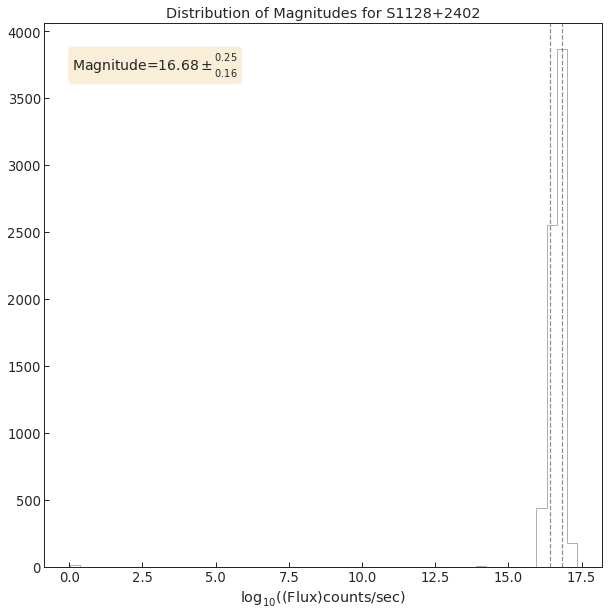

In [239]:
Name, MagnitudeList = list(), list()
for i in range(len(Names)):
    if RunBool[i] == 1:
        print "Working on %s"%Names[i]        
        
        # Load the data
        Calculated_Magnitude = np.loadtxt("/Users/edenmolina/PycharmProjects/Quasar/Lenstronomy/Mag_%s.txt"%Names[i])
        
        # If the calculated magnitdes's arent Nan or Inf if will be plotted
        try:
            plt.close()
            fig, ax = plt.subplots(figsize = (10, 10))
            mag_median = np.median(Calculated_Magnitude)
            mag_lstd = np.quantile(Calculated_Magnitude, .159)
            mag_ustd = np.quantile(Calculated_Magnitude, .841)
            
            err_min = round(mag_median-mag_lstd, 2)
            err_max = round(mag_ustd-mag_median, 2)
#             print "The Magnitude for %s is "%Names[i], mag_median
            ax.hist(Calculated_Magnitude, bins = 50, color = '#A29C9B', histtype='step')
            ax.axvline(x=mag_lstd, color = 'k', linestyle= '--', alpha = .5, markersize = .1)
            ax.axvline(x=mag_ustd, color = 'k', linestyle= '--', alpha = .5, markersize = .1)
            plt.title("Distribution of Magnitudes for %s"%Names[i])
            plt.xlabel(r'$\log_{10}({\rm (Flux)counts/sec})$')
            
            # Making a textbox displaying the statistics for calculated magnitude
            textstr = '\n'.join((
                r'Magnitude=$%.2f \pm ^{%s}_{%s}$' % (mag_median, err_min, err_max),))

            # these are matplotlib.patch.Patch properties
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

            # place a text box in upper left in axes coords
            ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
                    verticalalignment='top', bbox=props)

            plt.savefig("/Users/edenmolina/Desktop/FluxPlots/%s.png" %Names[i])

            Name.append(Names[i])
            MagnitudeList.append(mag_median)
        except:
            print "Either nan or inf magnitude calculated."
            print "Shape of Calculated Magnitude Array: ", np.shape(Calculated_Magnitude)[0]
            print "Non-NaN Values Are: ", Calculated_Magnitude[~np.isnan(Calculated_Magnitude)]
            print "\t", "There are this many Non-NaN : ", np.shape(Calculated_Magnitude[~np.isnan(Calculated_Magnitude)])[0]
            print "Number of inf: ", Calculated_Magnitude[np.isinf(Calculated_Magnitude)]
            print '\t', "There are this many inf : ", np.shape(Calculated_Magnitude[np.isinf(Calculated_Magnitude)])[0]
            print "NaN Values Are: ", Calculated_Magnitude[np.isnan(Calculated_Magnitude)]
            print '\t', "There are this many NaN : ", np.shape(Calculated_Magnitude[np.isnan(Calculated_Magnitude)])[0]
            print ("The Unique Values are: "), np.unique(Calculated_Magnitude)
            print '\t', "The unique values are: ", np.shape(np.unique(Calculated_Magnitude))[0], '\n'

            try:
                print "Calculating values that aren't nan or inf"
                Calculated_Magnitude = Calculated_Magnitude[~np.isnan(Calculated_Magnitude)]
                Calculated_Magnitude = Calculated_Magnitude[~np.isinf(Calculated_Magnitude)]
                print ("NON INF NON NAN ARRAY IS NOW", Calculated_Magnitude)
                plt.close()
                fig, ax = plt.subplots(figsize = (10, 10))
                mag_median = np.median(Calculated_Magnitude)
                mag_lstd = np.quantile(Calculated_Magnitude, .159)
                mag_ustd = np.quantile(Calculated_Magnitude, .841)

                err_min = round(mag_median-mag_lstd, 2)
                err_max = round(mag_ustd-mag_median, 2)
    #             print "The Magnitude for %s is "%Names[i], mag_median
                ax.hist(Calculated_Magnitude, bins = 50, color = '#A29C9B', histtype='step')
                ax.axvline(x=mag_lstd, color = 'k', linestyle= '--', alpha = .5, markersize = .1)
                ax.axvline(x=mag_ustd, color = 'k', linestyle= '--', alpha = .5, markersize = .1)
                plt.title("Distribution of Magnitudes for %s"%Names[i])
                plt.xlabel(r'$\log_{10}({\rm (Flux)counts/sec})$')

                # Making a textbox displaying the statistics for calculated magnitude
                textstr = '\n'.join((
                    r'Magnitude=$%.2f \pm ^{%s}_{%s}$' % (mag_median, err_min, err_max),))

                # these are matplotlib.patch.Patch properties
                props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

                # place a text box in upper left in axes coords
                ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
                        verticalalignment='top', bbox=props)

                plt.savefig("/Users/edenmolina/Desktop/FluxPlots/%s_had_Nan_or_Inf.png" %Names[i])

                Name.append(Names[i])
                MagnitudeList.append(mag_median)
            except:
                print ("All values were either NaN or Inf")
            
    else:
        continue
#         print "Skipping %s" % Names[i], "\n"

In [240]:
for i, name in enumerate (Name):
    print name, MagnitudeList[i]
MagnitudeDF = pd.DataFrame({'Name': Name, 'Lenstronomy Magnitude': MagnitudeList})

J0047 12.586833613913726
J0246sel 13.30500205219844
J0806 9.707497530990139
J1650 16.730101005473433
J2209 15.17029511400659
JU673 9.595947240415839
J2211+1929 15.1057791708458
J2257+2349 5.980159264071048
J2353-0539 0.012651740622608047
J0235-2433 16.658522752386883
J2213-2652 2.825657627619182
J0140+4107 11.781760689304857
J0245-0557 1.3259820433431164
J0246-1845 22.76693738415515
J0417+3325 7.401199025857405
J0446-3102 0.012845823426662739
J0949+4208 17.560400347603824
J1012-0307 5.726284395963983
S1128+2402 16.68393712677387


In [241]:
def getLensLightResult(Path, LensName):
    """
    path: path to the pickle file
    LensName: name of the lens, used for locating a pickled file
    
    returns: Calculated Magnitude
    """

    # Get pickled data
    lens_light_result, chain= getPickledData(Path, LensName)
    print (lens_light_result[0])
#     print (lens_light_result[0]['n_sersic'])
    return lens_light_result[0]['n_sersic'], lens_light_result[0]['R_sersic']

In [242]:
n_sersic_list = list()
out_names_list = list()
R_e_list = list()
for i in range(len(Names)):
    if RunBool[i] == 1:
        # Get lens light results

        lens_light_result_i, R_sersic_i = getLensLightResult("/Users/edenmolina/PycharmProjects/Quasar/Lenstronomy", Names[i])
        n_sersic_list.append(lens_light_result_i)
        out_names_list.append(Names[i])
        R_e_list.append(R_sersic_i)

{'R_sersic': 0.9608192641037128, 'n_sersic': 2.4304473193486325, 'center_x': 0, 'center_y': 0, 'amp': 0.13310209410857982, 'e1': -0.003166537156054028, 'e2': -0.13412310277062925}
{'R_sersic': 0.13453825365579228, 'n_sersic': 3.4570088075201233, 'center_x': 0, 'center_y': 0, 'amp': 0.9232435737522344, 'e1': 0.14879066573682592, 'e2': -0.07148253017069045}
{'R_sersic': 0.2899071943670122, 'n_sersic': 2, 'center_x': 0, 'center_y': 0, 'amp': 0.47589508072872255, 'e1': -0.043174872237653025, 'e2': 0.0031831713463195744}
{'R_sersic': 1.1900433622829025, 'n_sersic': 4.260574792999413, 'center_x': -0.004970999999999837, 'center_y': -0.004970999999999837, 'amp': 0.04867680051503411, 'e1': -0.07202880366628482, 'e2': -0.0879698792646945}
{'R_sersic': 0.25080524225798384, 'n_sersic': 2, 'center_x': 0, 'center_y': 0, 'amp': 0.5797767284244506, 'e1': 0.19208176691066597, 'e2': 0.05865205465871191}
{'R_sersic': 1.5513758328224299, 'n_sersic': 2, 'center_x': 0, 'center_y': 0, 'amp': 0.20021911370594

In [243]:
NSersicDF = pd.DataFrame({'Name': out_names_list, 'Lenstronomy n_sersic': n_sersic_list, 'Lenstronomy R_e':R_e_list})

In [244]:
DF = MagnitudeDF.merge(NSersicDF, on='Name')

In [245]:
DF[['Name', 'Lenstronomy Magnitude', 'Lenstronomy n_sersic', 'Lenstronomy R_e']]

,Name,Lenstronomy Magnitude,Lenstronomy n_sersic,Lenstronomy R_e
0,J0047,12.586834,2.430447,0.960819
1,J0246sel,13.305002,3.457009,0.134538
2,J0806,9.707498,2.000000,0.289907
3,J1650,16.730101,2.000000,0.250805
4,J2209,15.170295,2.000000,1.551376
5,JU673,9.595947,3.119461,0.399478
6,J2211+1929,15.105779,0.502401,0.704038
7,J2257+2349,5.980159,2.771702,0.524064
8,J2353-0539,0.012652,2.000000,1.713849
9,J0235-2433,16.658523,4.999044,1.198910
